In [ ]:
# IMPORTANT: SOME KAGGLE DATA SOURCES ARE PRIVATE
# RUN THIS CELL IN ORDER TO IMPORT YOUR KAGGLE DATA SOURCES.
import kagglehub
kagglehub.login()


In [ ]:
# IMPORTANT: RUN THIS CELL IN ORDER TO IMPORT YOUR KAGGLE DATA SOURCES,
# THEN FEEL FREE TO DELETE THIS CELL.
# NOTE: THIS NOTEBOOK ENVIRONMENT DIFFERS FROM KAGGLE'S PYTHON
# ENVIRONMENT SO THERE MAY BE MISSING LIBRARIES USED BY YOUR
# NOTEBOOK.

divyasribhargavi_clean_data_path = kagglehub.dataset_download('divyasribhargavi/clean-data')

print('Data source import complete.')


In [ ]:
## This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

#import os
#for dirname, _, filenames in os.walk('/kaggle/input'):
 #   for filename in filenames:
  #      print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All"
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/clean-data/clean_data.xlsx


In [105]:
import pandas as pd

In [106]:
# Load the dataset
df = pd.read_excel("/content/clean-data.xlsx")

In [107]:
df.head(1)

,Unnamed: 0,nct_id,Study Title,Study URL,Acronym,Study Status,Brief Summary,Study Results,Conditions,Interventions,...,minimum_age,maximum_age,healthy_volunteers,population,criteria,gender_description,gender_based,adult,child,older_adult
0,0,NCT04841499,Effects of a Seven-day BASISÃ¢â€žÂ¢ Supplement...,https://clinicaltrials.gov/study/NCT04841499,NaN,COMPLETED,The purpose of this study is to determine whet...,NO,Menopause,DRUG: BASISÃ¢â€žÂ¢ (Crystalline Nicotinamide R...,...,35 Years,NaN,t,NaN,"""Inclusion Criteria:~* 35 years of age or olde...",Biological female as determined at birth,t,t,f,t


In [108]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9937 entries, 0 to 9936
Data columns (total 39 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   Unnamed: 0                  9937 non-null   int64  
 1   nct_id                      9937 non-null   object 
 2   Study Title                 9937 non-null   object 
 3   Study URL                   9937 non-null   object 
 4   Acronym                     2452 non-null   object 
 5   Study Status                9937 non-null   object 
 6   Brief Summary               9937 non-null   object 
 7   Study Results               9937 non-null   object 
 8   Conditions                  9937 non-null   object 
 9   Interventions               9937 non-null   object 
 10  Primary Outcome Measures    9937 non-null   object 
 11  Secondary Outcome Measures  7676 non-null   object 
 12  Other Outcome Measures      939 non-null    object 
 13  Sponsor                     9919 

In [109]:
!pip install -q sentence-transformers xgboost


## Cleaning Study Title

In [110]:
# Fill missing values and preprocess "Study Title"
df['Study Title'] = df['Study Title'].fillna("").str.lower().str.replace(r"[^a-z0-9\s]", "", regex=True)

 ## Define the function for cleaning interventions

In [111]:
# Extract Interventions and classify them
def extract_interventions(intervention_text):
    if pd.isna(intervention_text):
        return {"DRUG": [], "DEVICE": [], "BIOLOGICAL": [], "PROCEDURE": []}

    interventions = {"DRUG": [], "DEVICE": [], "BIOLOGICAL": [], "PROCEDURE": []}
    items = str(intervention_text).split('|')

    for item in items:
        if 'DRUG:' in item:
            interventions["DRUG"].append(item.split('DRUG:')[1].strip().lower())
        elif 'DEVICE:' in item:
            interventions["DEVICE"].append(item.split('DEVICE:')[1].strip().lower())
        elif 'BIOLOGICAL:' in item:
            interventions["BIOLOGICAL"].append(item.split('BIOLOGICAL:')[1].strip().lower())
        elif 'PROCEDURE:' in item:
            interventions["PROCEDURE"].append(item.split('PROCEDURE:')[1].strip().lower())

    return interventions

In [112]:
# Apply classification
df['interventions'] = df['Interventions'].apply(extract_interventions)

In [113]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9937 entries, 0 to 9936
Data columns (total 40 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   Unnamed: 0                  9937 non-null   int64  
 1   nct_id                      9937 non-null   object 
 2   Study Title                 9937 non-null   object 
 3   Study URL                   9937 non-null   object 
 4   Acronym                     2452 non-null   object 
 5   Study Status                9937 non-null   object 
 6   Brief Summary               9937 non-null   object 
 7   Study Results               9937 non-null   object 
 8   Conditions                  9937 non-null   object 
 9   Interventions               9937 non-null   object 
 10  Primary Outcome Measures    9937 non-null   object 
 11  Secondary Outcome Measures  7676 non-null   object 
 12  Other Outcome Measures      939 non-null    object 
 13  Sponsor                     9919 

## SBERT for Study Title

In [114]:
from sentence_transformers import SentenceTransformer

# Load SBERT model (efficient and lightweight)
model = SentenceTransformer('all-MiniLM-L6-v2')

# Generate embeddings for "Study Title"
study_titles = df['Study Title'].tolist()
embeddings = model.encode(study_titles, batch_size=32, show_progress_bar=True)


Batches:   0%|          | 0/311 [00:00<?, ?it/s]

In [115]:
def get_primary_intervention(interventions):
    for category in ["DRUG", "DEVICE", "BIOLOGICAL", "PROCEDURE"]:
        if interventions[category]:
            return category
    return "OTHER"

df['Primary Intervention'] = df['interventions'].apply(get_primary_intervention)

In [116]:
df.head(1)

,Unnamed: 0,nct_id,Study Title,Study URL,Acronym,Study Status,Brief Summary,Study Results,Conditions,Interventions,...,healthy_volunteers,population,criteria,gender_description,gender_based,adult,child,older_adult,interventions,Primary Intervention
0,0,NCT04841499,effects of a sevenday basis supplementation on...,https://clinicaltrials.gov/study/NCT04841499,NaN,COMPLETED,The purpose of this study is to determine whet...,NO,Menopause,DRUG: BASISÃ¢â€žÂ¢ (Crystalline Nicotinamide R...,...,t,NaN,"""Inclusion Criteria:~* 35 years of age or olde...",Biological female as determined at birth,t,t,f,t,{'DRUG': ['basisã¢â€žâ¢ (crystalline nicotinam...,DRUG


In [117]:
df.count()

,0
Unnamed: 0,9937
nct_id,9937
Study Title,9937
Study URL,9937
Acronym,2452
Study Status,9937
Brief Summary,9937
Study Results,9937
Conditions,9937
Interventions,9937


In [118]:
# List of required columns
required_columns = [
    "nct_id", "Study Title", "Study Results", "Sponsor", "Sex", "Age",
    "Enrollment", "Funder Type", "Time taken for Enrollment",
    "healthy_volunteers", "adult", "child", "older_adult",
    "Primary Intervention"
]

In [119]:
# Create a modified dataset with only the required columns
modified_df = df[required_columns]

In [120]:
modified_df.head()

,nct_id,Study Title,Study Results,Sponsor,Sex,Age,Enrollment,Funder Type,Time taken for Enrollment,healthy_volunteers,adult,child,older_adult,Primary Intervention
0,NCT04841499,effects of a sevenday basis supplementation on...,NO,University of South Alabama,FEMALE,"ADULT, OLDER_ADULT",40.0,OTHER,3.0,t,t,f,t,DRUG
1,NCT03020641,peritoneal damage in laparoscopic surgery,YES,Fundacion para la Investigacion Biomedica del ...,ALL,"ADULT, OLDER_ADULT",100.0,OTHER,27.0,f,t,f,t,PROCEDURE
2,NCT03727620,doxycycline in the treatment of aggressive per...,NO,Mohammed V Souissi University,ALL,"CHILD, ADULT",24.0,OTHER,5.0,t,t,t,f,DRUG
3,NCT03162926,a safety and tolerability study of vc02 combin...,NO,ViaCyte,ALL,"ADULT, OLDER_ADULT",3.0,INDUSTRY,7.0,f,t,f,t,OTHER
4,NCT04434313,treatment of hemiparetic gait impairments usin...,NO,"Moterum Technologies, Inc.",ALL,"ADULT, OLDER_ADULT",6.0,INDUSTRY,8.0,f,t,f,t,DEVICE


In [ ]:
# Save the modified dataset to Kaggle's working directory for future use
modified_df.to_csv("/kaggle/working/modified_dataset.csv", index=False)

 ## Study Results

In [121]:
# Encode 'Study Results' as 0 (No) and 1 (Yes) using .loc[]
modified_df.loc[:, 'Study Results'] = modified_df['Study Results'].map({'NO': 0, 'YES': 1})


## Sponsors

In [122]:
# Clean the 'Sponsor' column
def clean_text(text):
    if pd.isna(text):  # Handle missing values
        return ""
    text = text.lower()  # Convert to lowercase
    text = text.strip()  # Remove leading/trailing spaces
    text = text.replace(",", "")  # Remove commas
    text = " ".join(text.split())  # Remove extra spaces
    return text

# Apply cleaning to 'Sponsor' using .loc[]
modified_df.loc[:, 'Sponsor'] = modified_df['Sponsor'].apply(clean_text)

In [123]:
# Display unique cleaned values for verification
print(modified_df['Sponsor'].unique())

['university of south alabama'
 'fundacion para la investigacion biomedica del hospital universitario ramon y cajal'
 'mohammed v souissi university' ...
 'shaukat khanum memorial cancer hospital & research centre'
 'rti surgical' 'sir run run shaw hospital']


In [124]:
from sentence_transformers import SentenceTransformer

# Load SBERT model (efficient and lightweight)
sbert_model = SentenceTransformer('all-MiniLM-L6-v2')

# Generate embeddings for 'Sponsor'
sponsor_embeddings = sbert_model.encode(modified_df['Sponsor'].tolist(), batch_size=32, show_progress_bar=True)

# Convert embeddings into a DataFrame for further processing
import numpy as np
sponsor_embeddings_df = pd.DataFrame(sponsor_embeddings, columns=[f'Sponsor_Embedding_{i}' for i in range(sponsor_embeddings.shape[1])])

# Concatenate embeddings back to the modified DataFrame
# modified_df = pd.concat([modified_df.reset_index(drop=True), sponsor_embeddings_df], axis=1)

Batches:   0%|          | 0/311 [00:00<?, ?it/s]

In [ ]:
# Load SBERT model (efficient and lightweight)
model = SentenceTransformer('all-MiniLM-L6-v2')

# Generate embeddings for "Study Title"
sponsor_titles = modified_df['Sponsor'].tolist()
sponsor_embeddings = model.encode(study_titles, batch_size=32, show_progress_bar=True)


### |-> Creating embeddings for Sponsor and Study Title

In [125]:
 # Convert embeddings into a DataFrame for further processing
sponsor_embeddings_df = pd.DataFrame(sponsor_embeddings, columns=[f'Sponsor_Embedding_{i}' for i in range(sponsor_embeddings.shape[1])])

In [126]:
 # Convert embeddings into a DataFrame for further processing
import numpy as np
study_title_embeddings_df = pd.DataFrame(embeddings, columns=[f'Study_Title_Embedding_{i}' for i in range(embeddings.shape[1])])

## Sex

In [127]:
# Check unique values in 'Sex'
print("Unique values in 'Sex':", modified_df['Sex'].unique())

# Encode 'Sex' as categorical variables
modified_df.loc[:, 'Sex'] = modified_df['Sex'].map({'ALL': 0, 'MALE': 1, 'FEMALE': 2})

Unique values in 'Sex': ['FEMALE' 'ALL' 'MALE' nan]


In [128]:
# One-hot encode the "Primary Intervention" column
primary_intervention_encoded = pd.get_dummies(modified_df['Primary Intervention'], prefix='Primary_Intervention')

# Concatenate one-hot encoded columns back to the original DataFrame
modified_df = pd.concat([modified_df, primary_intervention_encoded], axis=1)

# Drop the original "Primary Intervention" column if no longer needed
#df.drop(columns=['Primary Intervention'], inplace=True)

print("One-hot encoding completed successfully!")
print(df.head())


One-hot encoding completed successfully!
   Unnamed: 0       nct_id                                        Study Title  \
0           0  NCT04841499  effects of a sevenday basis supplementation on...   
1           1  NCT03020641          peritoneal damage in laparoscopic surgery   
2           2  NCT03727620  doxycycline in the treatment of aggressive per...   
3           3  NCT03162926  a safety and tolerability study of vc02 combin...   
4           4  NCT04434313  treatment of hemiparetic gait impairments usin...   

                                      Study URL Acronym Study Status  \
0  https://clinicaltrials.gov/study/NCT04841499     NaN    COMPLETED   
1  https://clinicaltrials.gov/study/NCT03020641     NaN    COMPLETED   
2  https://clinicaltrials.gov/study/NCT03727620     NaN    COMPLETED   
3  https://clinicaltrials.gov/study/NCT03162926     NaN    COMPLETED   
4  https://clinicaltrials.gov/study/NCT04434313     NaN    COMPLETED   

                                       

In [129]:
modified_df.head()

,nct_id,Study Title,Study Results,Sponsor,Sex,Age,Enrollment,Funder Type,Time taken for Enrollment,healthy_volunteers,adult,child,older_adult,Primary Intervention,Primary_Intervention_BIOLOGICAL,Primary_Intervention_DEVICE,Primary_Intervention_DRUG,Primary_Intervention_OTHER,Primary_Intervention_PROCEDURE
0,NCT04841499,effects of a sevenday basis supplementation on...,0,university of south alabama,2.0,"ADULT, OLDER_ADULT",40.0,OTHER,3.0,t,t,f,t,DRUG,False,False,True,False,False
1,NCT03020641,peritoneal damage in laparoscopic surgery,1,fundacion para la investigacion biomedica del ...,0.0,"ADULT, OLDER_ADULT",100.0,OTHER,27.0,f,t,f,t,PROCEDURE,False,False,False,False,True
2,NCT03727620,doxycycline in the treatment of aggressive per...,0,mohammed v souissi university,0.0,"CHILD, ADULT",24.0,OTHER,5.0,t,t,t,f,DRUG,False,False,True,False,False
3,NCT03162926,a safety and tolerability study of vc02 combin...,0,viacyte,0.0,"ADULT, OLDER_ADULT",3.0,INDUSTRY,7.0,f,t,f,t,OTHER,False,False,False,True,False
4,NCT04434313,treatment of hemiparetic gait impairments usin...,0,moterum technologies inc.,0.0,"ADULT, OLDER_ADULT",6.0,INDUSTRY,8.0,f,t,f,t,DEVICE,False,True,False,False,False


## Age

In [130]:
# Create binary columns for each age group
modified_df['Older_Adult'] = modified_df['Age'].str.contains('OLDER_ADULT', na=False).astype(int)
modified_df['Adult'] = modified_df['Age'].str.contains('ADULT', na=False).astype(int)
modified_df['Child'] = modified_df['Age'].str.contains('CHILD', na=False).astype(int)

# Drop the original 'Age' column if no longer needed
modified_df.drop(columns=['Age'], inplace=True)


## Funder_Type

In [131]:
# One-hot encode 'Funder Type'
funder_type_encoded = pd.get_dummies(modified_df['Funder Type'], prefix='Funder_Type')

# Concatenate the encoded columns back to the DataFrame
modified_df = pd.concat([modified_df.reset_index(drop=True), funder_type_encoded], axis=1)

# Drop the original column if no longer needed
modified_df.drop(columns=['Funder Type'], inplace=True)

## Healthy_Volunteers

In [132]:
# Encode 'healthy_volunteers' as 0 (false) and 1 (true)
modified_df.loc[:, 'healthy_volunteers'] = modified_df['healthy_volunteers'].map({'f': 0, 't': 1})

## Adult, Older_Adult, Child

In [133]:
# Convert t/f to 0/1 for 'adult', 'child', and 'older_adult'
for col in ['adult', 'child', 'older_adult']:
    modified_df.loc[:, col] = modified_df[col].map({'f': 0, 't': 1})

In [134]:
modified_df.head()

,nct_id,Study Title,Study Results,Sponsor,Sex,Enrollment,Time taken for Enrollment,healthy_volunteers,adult,child,...,Adult,Child,Funder_Type_FED,Funder_Type_INDIV,Funder_Type_INDUSTRY,Funder_Type_NETWORK,Funder_Type_NIH,Funder_Type_OTHER,Funder_Type_OTHER_GOV,Funder_Type_UNKNOWN
0,NCT04841499,effects of a sevenday basis supplementation on...,0,university of south alabama,2.0,40.0,3.0,1.0,1.0,0.0,...,1,0,False,False,False,False,False,True,False,False
1,NCT03020641,peritoneal damage in laparoscopic surgery,1,fundacion para la investigacion biomedica del ...,0.0,100.0,27.0,0.0,1.0,0.0,...,1,0,False,False,False,False,False,True,False,False
2,NCT03727620,doxycycline in the treatment of aggressive per...,0,mohammed v souissi university,0.0,24.0,5.0,1.0,1.0,1.0,...,1,1,False,False,False,False,False,True,False,False
3,NCT03162926,a safety and tolerability study of vc02 combin...,0,viacyte,0.0,3.0,7.0,0.0,1.0,0.0,...,1,0,False,False,True,False,False,False,False,False
4,NCT04434313,treatment of hemiparetic gait impairments usin...,0,moterum technologies inc.,0.0,6.0,8.0,0.0,1.0,0.0,...,1,0,False,False,True,False,False,False,False,False


In [135]:
# Display all column names in the modified_df DataFrame
print("Column Names in modified_df:")
print(modified_df.columns.tolist())

Column Names in modified_df:
['nct_id', 'Study Title', 'Study Results', 'Sponsor', 'Sex', 'Enrollment', 'Time taken for Enrollment', 'healthy_volunteers', 'adult', 'child', 'older_adult', 'Primary Intervention', 'Primary_Intervention_BIOLOGICAL', 'Primary_Intervention_DEVICE', 'Primary_Intervention_DRUG', 'Primary_Intervention_OTHER', 'Primary_Intervention_PROCEDURE', 'Older_Adult', 'Adult', 'Child', 'Funder_Type_FED', 'Funder_Type_INDIV', 'Funder_Type_INDUSTRY', 'Funder_Type_NETWORK', 'Funder_Type_NIH', 'Funder_Type_OTHER', 'Funder_Type_OTHER_GOV', 'Funder_Type_UNKNOWN']


In [139]:
columns_to_remove = [
    'nct_id', 'Study Results', 'Sponsor','adult', 'child', 'older_adult',
    'Primary Intervention',
    'Enrollment', 'Study Title'
]

final_df = modified_df.drop(columns=columns_to_remove)
print("Columns in final_df after removal:", final_df.columns.tolist())


Columns in final_df after removal: ['Sex', 'Time taken for Enrollment', 'healthy_volunteers', 'Primary_Intervention_BIOLOGICAL', 'Primary_Intervention_DEVICE', 'Primary_Intervention_DRUG', 'Primary_Intervention_OTHER', 'Primary_Intervention_PROCEDURE', 'Older_Adult', 'Adult', 'Child', 'Funder_Type_FED', 'Funder_Type_INDIV', 'Funder_Type_INDUSTRY', 'Funder_Type_NETWORK', 'Funder_Type_NIH', 'Funder_Type_OTHER', 'Funder_Type_OTHER_GOV', 'Funder_Type_UNKNOWN']


In [140]:
final_df.head()

,Sex,Time taken for Enrollment,healthy_volunteers,Primary_Intervention_BIOLOGICAL,Primary_Intervention_DEVICE,Primary_Intervention_DRUG,Primary_Intervention_OTHER,Primary_Intervention_PROCEDURE,Older_Adult,Adult,Child,Funder_Type_FED,Funder_Type_INDIV,Funder_Type_INDUSTRY,Funder_Type_NETWORK,Funder_Type_NIH,Funder_Type_OTHER,Funder_Type_OTHER_GOV,Funder_Type_UNKNOWN
0,2.0,3.0,1.0,False,False,True,False,False,1,1,0,False,False,False,False,False,True,False,False
1,0.0,27.0,0.0,False,False,False,False,True,1,1,0,False,False,False,False,False,True,False,False
2,0.0,5.0,1.0,False,False,True,False,False,0,1,1,False,False,False,False,False,True,False,False
3,0.0,7.0,0.0,False,False,False,True,False,1,1,0,False,False,True,False,False,False,False,False
4,0.0,8.0,0.0,False,True,False,False,False,1,1,0,False,False,True,False,False,False,False,False


In [141]:
final_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9937 entries, 0 to 9936
Data columns (total 19 columns):
 #   Column                           Non-Null Count  Dtype  
---  ------                           --------------  -----  
 0   Sex                              9915 non-null   object 
 1   Time taken for Enrollment        9915 non-null   float64
 2   healthy_volunteers               9914 non-null   object 
 3   Primary_Intervention_BIOLOGICAL  9937 non-null   bool   
 4   Primary_Intervention_DEVICE      9937 non-null   bool   
 5   Primary_Intervention_DRUG        9937 non-null   bool   
 6   Primary_Intervention_OTHER       9937 non-null   bool   
 7   Primary_Intervention_PROCEDURE   9937 non-null   bool   
 8   Older_Adult                      9937 non-null   int64  
 9   Adult                            9937 non-null   int64  
 10  Child                            9937 non-null   int64  
 11  Funder_Type_FED                  9937 non-null   bool   
 12  Funder_Type_INDIV   

In [142]:
# Concatenate embeddings back to the final DataFrame
final_df_with_embeddings = pd.concat([final_df.reset_index(drop=True), study_title_embeddings_df, sponsor_embeddings_df], axis=1)

In [143]:
from sklearn.model_selection import train_test_split

# Ensure no missing values in target variable ('Time taken for Enrollment')
final_df_with_embeddings = final_df_with_embeddings[final_df_with_embeddings['Time taken for Enrollment'].notnull()]

# Check if 'Primary Intervention' exists and has enough samples for each class; otherwise, skip stratification
if 'Primary Intervention' in final_df_with_embeddings.columns:
    # Get unique values and their counts in 'Primary Intervention'
    value_counts = final_df_with_embeddings['Primary Intervention'].value_counts()

    # Check if all classes have at least 2 samples
    if value_counts.min() >= 2:
        stratify_column = final_df_with_embeddings['Primary Intervention']
    else:
        print("'Primary Intervention' has classes with less than 2 samples. Skipping stratification.")
        stratify_column = None  # Disable stratification
else:
    print("'Primary Intervention' column not found. Skipping stratification.")
    stratify_column = None  # Disable stratification

# Define target variable (Y) and features (X)
X = final_df_with_embeddings.drop(columns=['Time taken for Enrollment'])
y = final_df_with_embeddings['Time taken for Enrollment']

# Perform stratified sampling (or random sampling if stratification is disabled)
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, stratify=stratify_column, random_state=42
)

print("Train and test sets created successfully!")

'Primary Intervention' column not found. Skipping stratification.
Train and test sets created successfully!


In [99]:
# Convert all values in 'Study Title' to strings
#X_train['Study Title'] = X_train['Study Title'].astype(str)
#X_test['Study Title'] = X_test['Study Title'].astype(str) - WE already removed this


In [100]:
from sklearn.preprocessing import LabelEncoder

# Create a LabelEncoder object
#label_encoder = LabelEncoder()

# Fit on combined unique values from both X_train and X_test
#all_study_titles = pd.concat([X_train['Study Title'], X_test['Study Title']]).unique()
#label_encoder.fit(all_study_titles)

# Transform the 'Study Title' column in both datasets
#X_train['Study Title'] = label_encoder.transform(X_train['Study Title'])
#X_test['Study Title'] = label_encoder.transform(X_test['Study Title'])
# Not required

In [144]:
!pip install xgboost


In [145]:
#from sklearn.preprocessing import LabelEncoder

# Create a LabelEncoder object
label_encoder = LabelEncoder()

# 1. Study Title
# X_train['Study Title'] = label_encoder.fit_transform(X_train['Study Title'])

# 2. Sex
X_train['Sex'] = label_encoder.fit_transform(X_train['Sex'])

# 3. healthy_volunteers
X_train['healthy_volunteers'] = X_train['healthy_volunteers'].map({'t': 1, 'f': 0})

In [146]:
# Check data types of X_train
print(X_train.dtypes)

# Identify non-numerical columns
non_numerical_columns = X_train.select_dtypes(include=['object']).columns.tolist()
print("Non-numerical columns:", non_numerical_columns)


Sex                                  int64
healthy_volunteers                 float64
Primary_Intervention_BIOLOGICAL       bool
Primary_Intervention_DEVICE           bool
Primary_Intervention_DRUG             bool
                                    ...   
Sponsor_Embedding_379              float32
Sponsor_Embedding_380              float32
Sponsor_Embedding_381              float32
Sponsor_Embedding_382              float32
Sponsor_Embedding_383              float32
Length: 786, dtype: object
Non-numerical columns: []


In [147]:
#from sklearn.preprocessing import LabelEncoder

# Create a LabelEncoder object
label_encoder = LabelEncoder()

# 1. Study Title
# X_train['Study Title'] = label_encoder.fit_transform(X_train['Study Title'])

# 2. Sex
X_test['Sex'] = label_encoder.fit_transform(X_test['Sex'])

# 3. healthy_volunteers
X_test['healthy_volunteers'] = X_test['healthy_volunteers'].map({'t': 1, 'f': 0})

In [148]:
# Check data types of X_train
print(X_test.dtypes)

# Identify non-numerical columns
non_numerical_columns = X_test.select_dtypes(include=['object']).columns.tolist()
print("Non-numerical columns:", non_numerical_columns)

Sex                                  int64
healthy_volunteers                 float64
Primary_Intervention_BIOLOGICAL       bool
Primary_Intervention_DEVICE           bool
Primary_Intervention_DRUG             bool
                                    ...   
Sponsor_Embedding_379              float32
Sponsor_Embedding_380              float32
Sponsor_Embedding_381              float32
Sponsor_Embedding_382              float32
Sponsor_Embedding_383              float32
Length: 786, dtype: object
Non-numerical columns: []


In [151]:
# Remove 'Study Title' and any other non-numerical columns from X_train and X_test
#columns_to_remove = ['Study Title']  # Add other non-numerical columns if needed
#X_train = X_train.drop(columns=columns_to_remove)
#X_test = X_test.drop(columns=columns_to_remove)

print("Columns in X_train after removal:", X_train.columns.tolist())


Columns in X_train after removal: ['Sex', 'healthy_volunteers', 'Primary_Intervention_BIOLOGICAL', 'Primary_Intervention_DEVICE', 'Primary_Intervention_DRUG', 'Primary_Intervention_OTHER', 'Primary_Intervention_PROCEDURE', 'Older_Adult', 'Adult', 'Child', 'Funder_Type_FED', 'Funder_Type_INDIV', 'Funder_Type_INDUSTRY', 'Funder_Type_NETWORK', 'Funder_Type_NIH', 'Funder_Type_OTHER', 'Funder_Type_OTHER_GOV', 'Funder_Type_UNKNOWN', 'Study_Title_Embedding_0', 'Study_Title_Embedding_1', 'Study_Title_Embedding_2', 'Study_Title_Embedding_3', 'Study_Title_Embedding_4', 'Study_Title_Embedding_5', 'Study_Title_Embedding_6', 'Study_Title_Embedding_7', 'Study_Title_Embedding_8', 'Study_Title_Embedding_9', 'Study_Title_Embedding_10', 'Study_Title_Embedding_11', 'Study_Title_Embedding_12', 'Study_Title_Embedding_13', 'Study_Title_Embedding_14', 'Study_Title_Embedding_15', 'Study_Title_Embedding_16', 'Study_Title_Embedding_17', 'Study_Title_Embedding_18', 'Study_Title_Embedding_19', 'Study_Title_Embedd

In [152]:
# Check data types of X_train
print(X_train.dtypes)

# Identify non-numerical columns
non_numerical_columns = X_train.select_dtypes(include=['object']).columns.tolist()
print("Non-numerical columns:", non_numerical_columns)

Sex                                  int64
healthy_volunteers                 float64
Primary_Intervention_BIOLOGICAL       bool
Primary_Intervention_DEVICE           bool
Primary_Intervention_DRUG             bool
                                    ...   
Sponsor_Embedding_379              float32
Sponsor_Embedding_380              float32
Sponsor_Embedding_381              float32
Sponsor_Embedding_382              float32
Sponsor_Embedding_383              float32
Length: 786, dtype: object
Non-numerical columns: []


In [153]:
# Check data types of X_train
print(X_test.dtypes)

# Identify non-numerical columns
non_numerical_columns = X_test.select_dtypes(include=['object']).columns.tolist()
print("Non-numerical columns:", non_numerical_columns)

Sex                                  int64
healthy_volunteers                 float64
Primary_Intervention_BIOLOGICAL       bool
Primary_Intervention_DEVICE           bool
Primary_Intervention_DRUG             bool
                                    ...   
Sponsor_Embedding_379              float32
Sponsor_Embedding_380              float32
Sponsor_Embedding_381              float32
Sponsor_Embedding_382              float32
Sponsor_Embedding_383              float32
Length: 786, dtype: object
Non-numerical columns: []


In [154]:
# Now create DMatrix objects with enable_categorical=True
dtrain = xgb.DMatrix(X_train, label=y_train, enable_categorical=True)
dtest = xgb.DMatrix(X_test, label=y_test, enable_categorical=True)

In [155]:
import xgboost as xgb
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import LabelEncoder  # Import LabelEncoder

# ... (Your existing code for data preparation and NaN handling) ...

# 1. Create a LabelEncoder object outside the loop:
label_encoder = LabelEncoder()

# Ensure X_test also has the same columns as X_train
for col in X_train.columns:
    if col not in X_test.columns:
        X_test[col] = 0  # or any suitable default value

# Apply label encoding to non-numerical columns in both X_train and X_test
for col in X_train.select_dtypes(include=['object']).columns:
    # Fit on the combined unique values from both X_train and X_test
    all_values = pd.concat([X_train[col], X_test[col]]).unique()
    label_encoder.fit(all_values)  # Fit the encoder on all unique values

    # Transform both X_train and X_test using .loc for assignment
    X_train.loc[:, col] = label_encoder.transform(X_train[col])
    X_test.loc[:, col] = label_encoder.transform(X_test[col])

    # Explicitly convert the encoded column to numeric type in both DataFrames
    X_train.loc[:, col] = pd.to_numeric(X_train[col])
    X_test.loc[:, col] = pd.to_numeric(X_test[col])

# Now create DMatrix objects with enable_categorical=True
dtrain = xgb.DMatrix(X_train, label=y_train, enable_categorical=True)
dtest = xgb.DMatrix(X_test, label=y_test, enable_categorical=True)

# ... (Rest of your XGBoost training and evaluation code) ...

In [156]:
import xgboost as xgb
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error

# ... (Your existing code for data preparation and NaN handling) ...

# 1. Create DMatrix objects:
dtrain = xgb.DMatrix(X_train, label=y_train, enable_categorical=True)
dtest = xgb.DMatrix(X_test, label=y_test, enable_categorical=True)

# 2. Define XGBoost parameters:
params = {
    'objective': 'reg:squarederror',
    'eval_metric': 'rmse',
    'tree_method': 'hist',
    'max_depth': 6,
    'subsample': 0.8,
    'colsample_bytree': 0.8,
    'learning_rate': 0.1,
    'n_estimators': 100,
    'verbosity': 1
}

# 3. Train the model with early stopping:
eval_set = [(dtrain, 'train'), (dtest, 'eval')]
model = xgb.train(
    params,
    dtrain,
    num_boost_round=1000,
    early_stopping_rounds=10,
    evals=eval_set,
    verbose_eval=10
)

# 4. Make predictions:
y_pred = model.predict(dtest)

# 5. Evaluate the model:
#rmse = mean_squared_error(y_test, y_pred, squared=False)
#print(f"RMSE: {rmse}")

# 6. Further analysis (optional):
# - Feature importance:
#   importance = model.get_score(importance_type='gain')
#   print(importance)
# - Visualizations:
#   xgb.plot_importance(model)
#   xgb.plot_tree(model, num_trees=0)

/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [22:23:16] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "n_estimators" } are not used.

  warnings.warn(smsg, UserWarning)


[0]	train-rmse:16.19032	eval-rmse:15.84813
[10]	train-rmse:13.62929	eval-rmse:14.93300
[20]	train-rmse:11.92715	eval-rmse:14.58463
[30]	train-rmse:10.75551	eval-rmse:14.44263
[40]	train-rmse:9.75703	eval-rmse:14.38807
[50]	train-rmse:8.96884	eval-rmse:14.36980
[60]	train-rmse:8.31252	eval-rmse:14.34838
[70]	train-rmse:7.78303	eval-rmse:14.33053
[80]	train-rmse:7.28774	eval-rmse:14.32255
[90]	train-rmse:6.85435	eval-rmse:14.29299
[98]	train-rmse:6.55219	eval-rmse:14.30928


In [157]:
# 4. Make predictions:
y_pred = model.predict(dtest)
print(y_pred)

[21.112568 21.356531 26.321663 ...  8.938513 28.589945 20.17564 ]


In [158]:
# 5. Evaluate the model (RMSE):
# rmse = mean_squared_error(y_test, y_pred, squared=False)  # Remove 'squared' argument
rmse = np.sqrt(mean_squared_error(y_test, y_pred)) # Calculate RMSE using NumPy
print(f"RMSE: {rmse}")

RMSE: 14.309277791811365


In [159]:
# 6. Define a threshold for classification (adapt as needed):
threshold = np.median(y_test)  # Example: Using the median as the threshold

In [160]:
# 7. Convert predictions to classes based on the threshold:
y_pred_classes = np.where(y_pred > threshold, 1, 0)
y_test_classes = np.where(y_test > threshold, 1, 0)

In [161]:
# 8. Calculate accuracy, precision, and F1 score:
from sklearn.metrics import accuracy_score, precision_score, f1_score # Import necessary functions

accuracy = accuracy_score(y_test_classes, y_pred_classes)
precision = precision_score(y_test_classes, y_pred_classes)
f1 = f1_score(y_test_classes, y_pred_classes)

print(f"Accuracy: {accuracy}")
print(f"Precision: {precision}")
print(f"F1 Score: {f1}")

Accuracy: 0.6137165910237015
Precision: 0.5681969394544245
F1 Score: 0.6903799514955538


In [162]:
!pip install matplotlib


In [163]:
import matplotlib.pyplot as plt


In [164]:
# 6. Feature importance:
importance = model.get_score(importance_type='gain')
print("Feature Importance:")
print(importance)

Feature Importance:
{'Sex': 384.65753173828125, 'Primary_Intervention_BIOLOGICAL': 79.77957153320312, 'Primary_Intervention_DEVICE': 54.02458572387695, 'Primary_Intervention_DRUG': 329.9837341308594, 'Primary_Intervention_OTHER': 1192.88525390625, 'Primary_Intervention_PROCEDURE': 298.1106262207031, 'Older_Adult': 3173.06640625, 'Adult': 227.4547119140625, 'Child': 3914.036376953125, 'Funder_Type_FED': 1026.5626220703125, 'Funder_Type_INDUSTRY': 1814.76904296875, 'Funder_Type_NIH': 47.55888366699219, 'Funder_Type_OTHER': 9.571556091308594, 'Study_Title_Embedding_0': 173.0733642578125, 'Study_Title_Embedding_1': 230.22361755371094, 'Study_Title_Embedding_2': 308.7678527832031, 'Study_Title_Embedding_3': 711.0887451171875, 'Study_Title_Embedding_4': 379.00787353515625, 'Study_Title_Embedding_5': 715.7449951171875, 'Study_Title_Embedding_6': 625.2657470703125, 'Study_Title_Embedding_7': 1303.9813232421875, 'Study_Title_Embedding_8': 575.1175537109375, 'Study_Title_Embedding_9': 384.212280

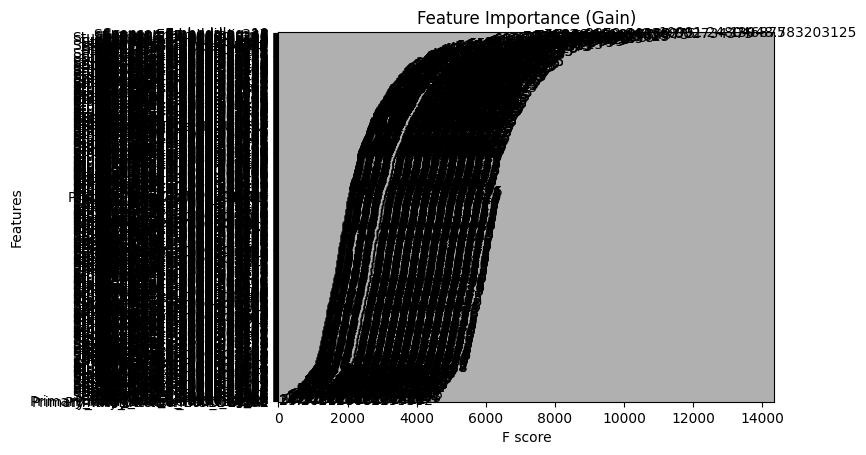

In [95]:
# 7. Feature importance plot:
xgb.plot_importance(model, importance_type='gain')
plt.title('Feature Importance (Gain)')
plt.savefig('feature_imp.png')
plt.show()

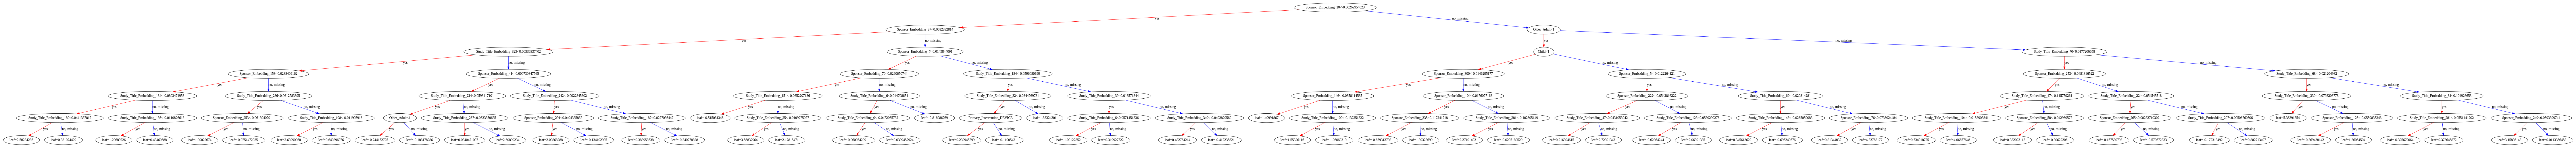

In [175]:
# 8. Plot a single tree:
xgb.plot_tree(model, num_trees=0)  # Plot the first tree
fig = plt.gcf()
fig.set_size_inches(150, 100)  # Adjust size as needed
plt.savefig('xgboost_tree.png')  # Save the figure to a file named 'xgboost_tree.png'
plt.show()

In [165]:
import numpy as np
from sklearn.metrics import r2_score

def smape(y_true, y_pred):
    """
    Calculates the Symmetric Mean Absolute Percentage Error (SMAPE).

    Args:
        y_true: The actual values.
        y_pred: The predicted values.

    Returns:
        The SMAPE value.
    """
    numerator = np.abs(y_true - y_pred)
    denominator = (np.abs(y_true) + np.abs(y_pred)) / 2
    return np.mean(numerator / denominator) * 100

# Calculate R-squared
r_squared = r2_score(y_test, y_pred)
print(f"R-squared: {r_squared}")

# Calculate SMAPE
smape_value = smape(y_test, y_pred)
print(f"SMAPE: {smape_value}")

R-squared: 0.20072212082369156
SMAPE: 68.09852719935472


In [166]:
!pip install shap


In [167]:
import shap
import xgboost as xgb
import matplotlib.pyplot as plt


In [170]:
# Use pred_contribs=True to get SHAP values directly from XGBoost
shap_values = model.predict(dtest, pred_contribs=True)

# The last column contains the bias term, so remove it
shap_values = shap_values[:, :-1]

# Convert to a DataFrame for better visualization
shap_df = pd.DataFrame(shap_values, columns=X_train.columns)

print("SHAP values calculated successfully!")


SHAP values calculated successfully!


In [171]:
# One-hot encode categorical features in both X_train and X_test
X_train_encoded = pd.get_dummies(X_train, drop_first=True)
X_test_encoded = pd.get_dummies(X_test, drop_first=True)

# Align columns in X_train_encoded and X_test_encoded
X_train_encoded, X_test_encoded = X_train_encoded.align(X_test_encoded, join='left', axis=1)
X_test_encoded = X_test_encoded.fillna(0)  # Fill missing columns in test set with 0


In [172]:
dtrain_encoded = xgb.DMatrix(X_train_encoded, label=y_train)
dtest_encoded = xgb.DMatrix(X_test_encoded, label=y_test)

params = {
    'objective': 'reg:squarederror',
    'eval_metric': 'rmse',
    'tree_method': 'hist',
    'max_depth': 6,
    'subsample': 0.8,
    'colsample_bytree': 0.8,
    'learning_rate': 0.1,
    'n_estimators': 100,
    'verbosity': 1
}

model = xgb.train(
    params,
    dtrain_encoded,
    num_boost_round=1000,
    early_stopping_rounds=10,
    evals=[(dtrain_encoded, 'train'), (dtest_encoded, 'eval')],
    verbose_eval=10
)


/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [22:41:06] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "n_estimators" } are not used.

  warnings.warn(smsg, UserWarning)


[0]	train-rmse:16.19032	eval-rmse:15.84813
[10]	train-rmse:13.62929	eval-rmse:14.93300
[20]	train-rmse:11.92715	eval-rmse:14.58463
[30]	train-rmse:10.75551	eval-rmse:14.44263
[40]	train-rmse:9.75703	eval-rmse:14.38807
[50]	train-rmse:8.96884	eval-rmse:14.36980
[60]	train-rmse:8.31252	eval-rmse:14.34838
[70]	train-rmse:7.78303	eval-rmse:14.33053
[80]	train-rmse:7.28774	eval-rmse:14.32255
[90]	train-rmse:6.85435	eval-rmse:14.29299
[97]	train-rmse:6.58836	eval-rmse:14.30049


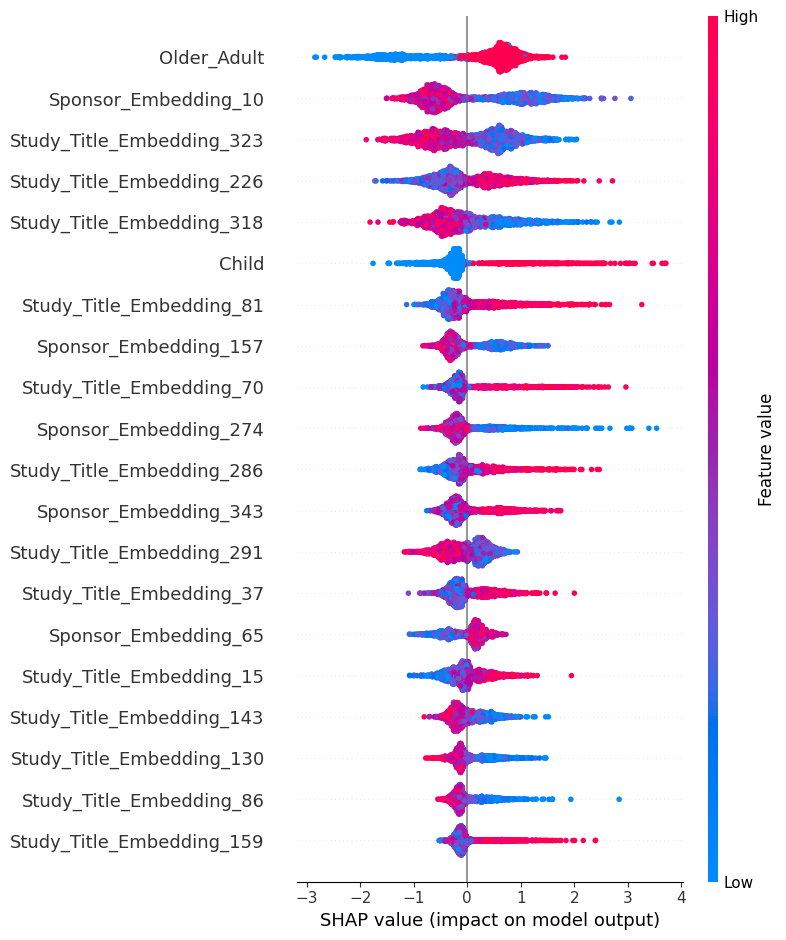

In [173]:
import shap

# Initialize SHAP TreeExplainer
explainer = shap.TreeExplainer(model)

# Calculate SHAP values for the test set
shap_values = explainer.shap_values(X_test_encoded)

# Visualize global feature importance
shap.summary_plot(shap_values, X_test_encoded)


SHAP summary plot saved successfully!


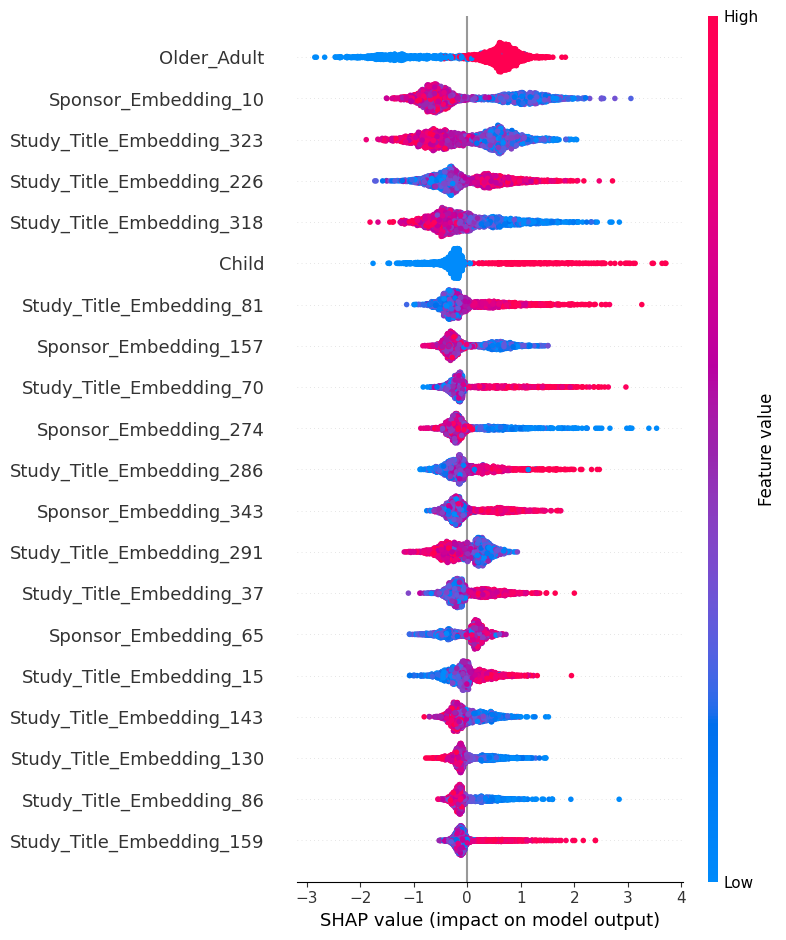

In [174]:
import matplotlib.pyplot as plt
import shap

# Visualize global feature importance and save the plot
shap.summary_plot(shap_values, X_test_encoded, show=False)
plt.savefig('/content/shap_summary_plot.png')  # Save as PNG
plt.savefig('/content/shap_summary_plot.pdf')  # Save as PDF (optional)

print("SHAP summary plot saved successfully!")


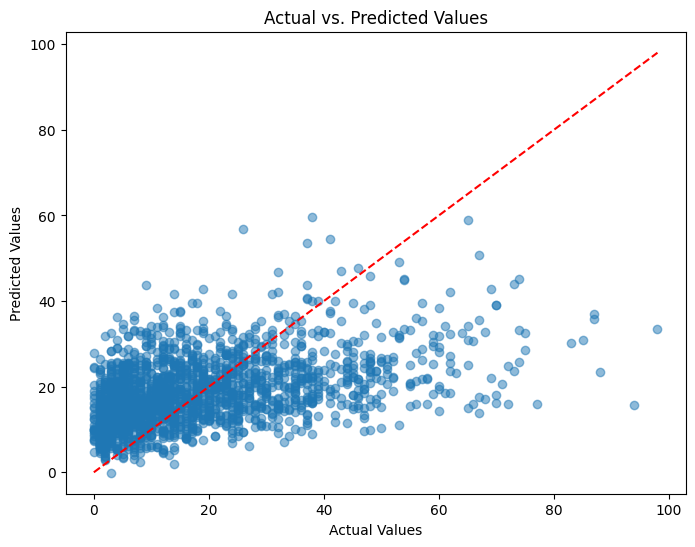

In [178]:
plt.figure(figsize=(8, 6))  # Adjust figure size if needed
plt.scatter(y_test, y_pred, alpha=0.5)  # Create scatter plot
plt.xlabel("Actual Values")
plt.ylabel("Predicted Values")
plt.title("Actual vs. Predicted Values")

   # Add a diagonal line for reference (perfect predictions)
plt.plot([min(y_test), max(y_test)], [min(y_test), max(y_test)], color='red', linestyle='--')
plt.savefig('actual_vs_predicted.png')  # Save the plot
plt.show()